<a href="https://colab.research.google.com/github/pidipidi/cs577_RLI/blob/master/assignment_1/problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1 - Original Dynamic Movement Primitives (DMPs)




## Environment Setup

In [1]:
import numpy as np
import sys, copy

## A. Implement the original DMPs that learn and reproduce a minimum-jerk trajectory.

In this problem, you will implement the original Dynamic Movement Primitives (DMPs) to learn and reproduce a minimum-jerk trajectory.

### Minimum-jerk *Trajectory*
Your first step is to implement a function that generates a minimum-jerk trajectory. This trajectory will serve as the demonstration data for imitation. Using this demonstration, you will then implement the original DMP formulation to reproduce the trajectory.

Let’s start by coding the minimum-jerk trajectory generator. Please place your implementation in the code block below.

In [2]:
def min_jerk(start, goal, dur, freq=100):
    """
    A function to generate a minimum-jerk trajectory.

    Parameters
    ----------
    start : array
        a vector of start position (e.g., np.array([0,0,0]))
    goal  : array
        a vector of goal position (e.g., np.array([1,2,1]))
    dur   : float
        time duration of the resulted trajectory
    freq  : float
        time frequency (Hz)

    Returns
    -------
    time : array
           a list of progress from 0 to 1
    X    : array
           a position trajectory from a start to a goal
    Xd   : array
           a velocity trajectory
    Xdd  : array
           an acceleration trajectory
    Xddd : array
           a jerk trajectory
    """
    if type(start) in [list, tuple]: start = np.array(start)
    if type(goal) in [list, tuple]: goal = np.array(goal)

    D = len(start) # dimension
    P = int(freq * dur) # the number of points

    time = []
    X  = []
    Xd = []
    Xdd  = []
    Xddd = []
    for i in range(P):
        # ------------------------------------------------------
        # Place your code here
        t = float(i)/float(P-1)

        time.append(t)
        X.append( start + (goal-start)*(10.0*(t)**3 - 15.*(t)**4 + 6*(t)**5) )
        Xd.append( (goal-start)/float(P)*(30.0*(t)**2 - 60.*(t)**3 + 30*(t)**4) )
        Xdd.append( (goal-start)/float(P)*(60.0*t - 180.*(t)**2 + 120*(t)**3) )
        Xddd.append( (goal-start)/float(P)*(60.0 - 360.*t + 360*(t)**2) )
        # ------------------------------------------------------

    return time, np.array(X), np.array(Xd), np.array(Xdd), np.array(Xddd)

Now, let’s verify that the min_jerk function generates a smooth trajectory from the start to the goal. You may enhance the sample code below to create clearer and more informative visualizations.

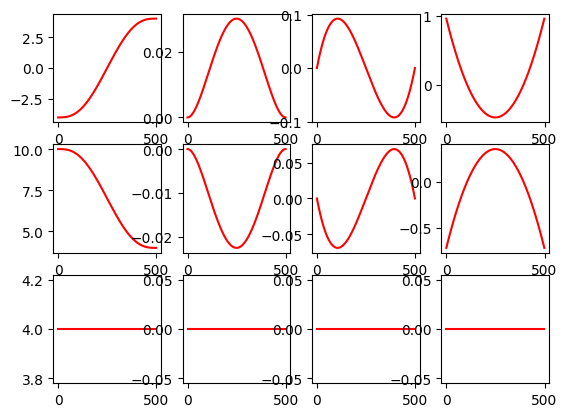

In [3]:
# start and goal
start = np.array([-4.0, 10.0, 4.0])
goal  = np.array([4.0, 4.0, 4.0])
N,D   = 2, len(start)

freq     = 100 #Hz
duration = 5.

_, trj, trj_vel, trj_acc, trj_jerk = min_jerk(start, goal, duration, freq)

# ------------------------------------------------------
# Place your code here to visualize the trajectories
length = len(trj)

import matplotlib.pyplot as plt
fig = plt.figure(1)

for i in range(D):
    ax = fig.add_subplot(D, 4, i*4+1)
    plt.plot(range(length), trj[:,i], 'r-', markersize=12)

    ax = fig.add_subplot(D, 4, i*4+2)
    plt.plot(range(length), trj_vel[:,i], 'r-', markersize=12)

    ax = fig.add_subplot(D, 4, i*4+3)
    plt.plot(range(length), trj_acc[:,i], 'r-', markersize=12)

    ax = fig.add_subplot(D, 4, i*4+4)
    plt.plot(range(length), trj_jerk[:,i], 'r-', markersize=12)

plt.show()
# ------------------------------------------------------

### Original DMP Formulation

Now, let’s formulate the original DMP equations:

- **Canonical System:**  
  <div align="center">
  $
  \tau \dot{s} = -\alpha s
  $
  </div>

- **Nonlinear Function:**  
  <div align="center">
  $
  f(s) = \frac{\sum_i w_i \, \phi_i(s)\, s}{\sum_i \phi_i(s)}
  $
  </div>  

- **Transformation System:**  
  <div align="center">
  $
  \tau \dot{v} = K(g - x) - Dv + (g - x_0) f, \quad \tau \dot{x} = v
  $
  </div>
  
Based on these equations, please complete the code blocks below to implement the original DMP formulation.

In [4]:
class OriginalFormulation(object):

    def __init__(self, K=50., D=None):
        self.K = K
        if D is None:
            D = 2.0 * np.sqrt(self.K)
        self.D = D

    def acceleration(self, x, dx, start, goal, tau, f, s):
        ''' return acceleration '''
        #------------------------------------------------------------
        # Place your code here
        return (self.K*(goal-x) - self.D*dx + (goal-start)*f) / tau
        #------------------------------------------------------------

    def fs(self, x, dx, ddx, start, goal, tau, s):
        ''' return nonlinear function value '''
        #------------------------------------------------------------
        # Place your code here
        return (tau*ddx - self.K*(goal-x) + self.D*dx) / (goal-start)
        #------------------------------------------------------------

In [5]:
class DMPs_discrete(object):

    def __init__(self, dims, bfs, dt=.01, tau=1., alpha=14, enable_improved=False, **kwargs):
        '''
        dims int: number of dynamic motor primitives
        bfs int: number of basis functions per DMP
        dt float: timestep for simulation
        tau float: scales the timestep
                   increase tau to make the system execute faster
        alpha float: canonical system parameter
        '''

        self.dmps = dims
        self.bfs  = bfs
        self.dt   = dt
        self.tau  = tau
        self.alpha = alpha/2.0
        self.alpha_x = alpha

        self.prep_centers_and_variances()

        if enable_improved is False:
            self.formulation = OriginalFormulation()
        else:
            self.formulation = ImprovedFormulation()

        return


    def prep_centers_and_variances(self):
        '''
        Set the centre of the Gaussian basis functions be spaced evenly
        throughout run time.
        '''
        self.c = np.zeros(self.bfs)
        self.h = np.zeros(self.bfs)

        t = np.linspace(0,1,self.bfs) *0.5

        # From DMP matlab code
        self.c = np.exp(-self.alpha_x*t)
        self.D = (np.diff(self.c)*0.55)**2
        self.D = np.append(self.D, self.D[-1])
        self.D = 1/self.D
        self.h = np.ones(self.bfs)*0.5


    def gen_psi(self, x):
        '''
        Generates the activity of the basis functions for a given state of the
        canonical system.

        x float: the current state of the canonical system
        '''
        if isinstance(x, np.ndarray):
            x = x[:,None]
        return np.exp(-self.h * (x - self.c)**2 * self.D)


    def gen_phase(self, n_steps, tau=None):
        """
        Generate phase for open loop movements.

        n_steps int: number of steps
        """
        if tau is None: tau = self.tau
        return np.exp(-self.alpha/tau * np.linspace(0, 1, n_steps))


    def learn(self, y_des):
        """
        Encode a set of weights from the input trajectories.

        y_des list/array: the desired trajectories of each DMP
                          should be shaped [dmps, run_time]
        """
        # Set variables
        n_samples, dims, n_steps = np.shape(y_des)
        self.n_steps = n_steps
        assert dims==self.dmps, "wrong dimensions"

        # Get start and goal
        self.y0   = np.mean(y_des[:,:,0], axis=0)
        self.goal = np.mean(y_des[:,:,-1], axis=0)

        # Calculate yd_des, ydd_des
        yd_des = np.diff(y_des) / self.dt
        yd_des = np.concatenate((np.zeros((n_samples, self.dmps, 1)), yd_des), axis=2)

        ydd_des = np.diff(yd_des) / self.dt
        ydd_des = np.concatenate((np.zeros((n_samples, self.dmps, 1)), ydd_des), axis=2)

        # Get a canonical system
        x_track = self.gen_phase(n_steps)

        #------------------------------------------------------------
        # Place your code here

        # Calculate f
        f_des = np.zeros((n_samples, self.dmps, n_steps))
        for i in range(n_samples):
            for j in range(self.dmps):
                f_des[i,j] = self.formulation.fs(y_des[i,j], yd_des[i,j], ydd_des[i,j],
                                                     self.y0[j:j+1], self.goal[j:j+1], self.tau,
                                                     x_track)

        # Calculate weights
        psi_track = self.gen_psi(x_track)

        x_track   = np.tile(x_track, n_samples)
        psi_track = np.tile(psi_track, (n_samples,1))
        f_des     = np.swapaxes(f_des, 0, 1)
        f_des     = f_des.reshape((self.dmps,n_samples*n_steps))

        self.w = np.zeros((self.dmps, self.bfs))
        for d in range(self.dmps):
            for b in range(self.bfs):
                numer = np.sum(x_track    * psi_track[:,b] * f_des[d,:])
                denom = np.sum(x_track**2 * psi_track[:,b]) + 1e-10
                self.w[d,b] = numer / denom
        #------------------------------------------------------------

        # set up tracking vectors
        y_track   = np.zeros((self.dmps, n_steps))
        yd_track  = np.zeros((self.dmps, n_steps))
        ydd_track = np.zeros((self.dmps, n_steps))

        y   = self.y0.copy()
        yd  = np.zeros(self.dmps)
        ydd = np.zeros(self.dmps)

        #------------------------------------------------------------
        # Place your code here
        x_track   = self.gen_phase(n_steps)
        psi_track = self.gen_psi(x_track)

        f = np.zeros((self.dmps,n_steps))
        for idx in range(self.dmps):
            f[idx] = np.sum(np.expand_dims(x_track,axis=1)*np.expand_dims(self.w[idx],axis=0)*psi_track, axis=1)/ np.sum(psi_track, axis=1)

        # Recover the demonstration using the learned weights (for confirmation)
        for t in range(n_steps):
            for idx in range(self.dmps):
                # Calcualte acceleration based on f(s)
                ydd[idx] = self.formulation.acceleration(y[idx], yd[idx], self.y0[idx],
                                                             self.goal[idx], self.tau,
                                                            f[idx,t], x_track[t])
                yd[idx] += ydd[idx] * self.dt * self.tau
                y[idx]  += yd[idx] * self.dt

            # record timestep
            y_track[:,t] = y
            yd_track[:,t] = yd
            ydd_track[:,t] = ydd
        #------------------------------------------------------------

        return y_track, yd_track, ydd_track


    def plan(self, y0=None, goal=None, **kwargs):
        '''
        Run the DMP system within a specific period.

        y0   list/array: start position
        goal list/array: goal position
        tau  float:      scales the timestep
                         increase tau to make the system execute faster
        '''

        if y0 is None: y0 = self.y0
        if goal is None: goal = self.goal
        n_steps = int(self.n_steps/self.tau)

        # set up tracking vectors
        y_track   = np.zeros((self.dmps, n_steps))
        yd_track  = np.zeros((self.dmps, n_steps))
        ydd_track = np.zeros((self.dmps, n_steps))
        x_track   = self.gen_phase(n_steps, self.tau)

        #------------------------------------------------------------
        # Place your code here
        y   = y0.copy()
        yd  = np.zeros(self.dmps)
        ydd = np.zeros(self.dmps)

        for t in range(n_steps):
            for idx in range(self.dmps):
                # Calcualte acceleration based on f(s)
                psi = self.gen_psi(x_track[t])
                f   = x_track[t] * ((np.dot(psi, self.w[idx])) / np.sum(psi))

                ydd[idx] = self.formulation.acceleration(y[idx], yd[idx], y0[idx], goal[idx], self.tau,
                                                        f, x_track[t])
                yd[idx] += ydd[idx] * self.tau * self.dt
                y[idx]  += yd[idx] * self.dt

            # record timestep
            y_track[:,t] = y
            yd_track[:,t] = yd
            ydd_track[:,t] = ydd
        #------------------------------------------------------------

        return y_track, yd_track, ydd_track


    def plot_traj(self, trajs_demo, trajs_gen, axis_num=0):
        """Plot trajectories over an axis """

        fig = plt.figure()
        plt.title('Trajectory (X) - Demo (Td) and generated (Tg)')
        for i in range(len(trajs_demo)):
            plt.plot(trajs_demo[i,axis_num,:], 'r--', label='Td')
        for i in range(len(trajs_gen)):
            plt.plot(trajs_gen[i,axis_num,:],'g-', label='Tg')

        plt.legend()
        plt.show()

    def plot_basis(self):
        """Plot basis functions """
        fig = plt.figure()

        x = self.gen_phase(200)

        for idx in range(len(self.c)):
            psi = self.gen_psi(x)
            plt.plot(x, psi)

        plt.show()

    def plot_f(self, f, f_des=None):
        """Plot nonlinear functions """

        fig = plt.figure()
        plt.plot(f)
        if f_des is not None:
            plt.plot(f_des, '--')
        plt.show()

    def plot_canonical_sys(self):
        """Plot the phase change in the canonical system """
        x = self.gen_phase(200)

        fig = plt.figure()
        plt.plot(x)
        plt.show()

### Phase Plots

Please, plot phases from the canonical system and your basis functions over phases.

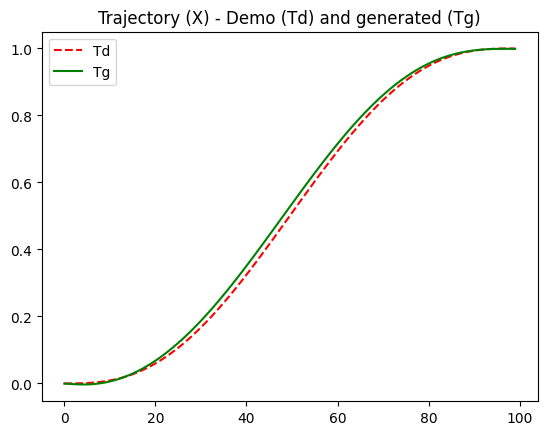

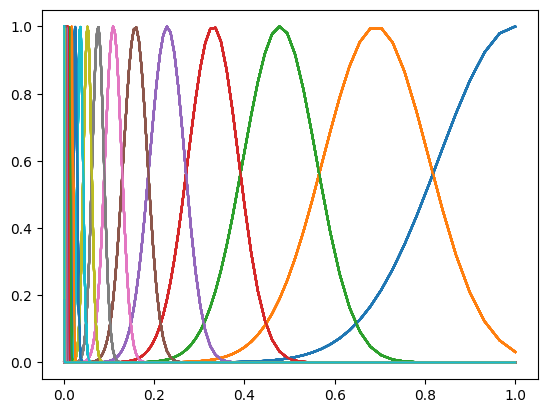

In [7]:
def min_jerk_trajs(dims=1, n_samples=10, freq=100, duration=1., add_noise=False):
    """
    Generate a set of minimum-jerk trajectories [n_samples x dims x n_length].

    dims   : the dimension of a sample trajectory
    n_samples: the number of trajectories
    freq     : frequency
    duration : time length of trajectories
    add_noise: add gaussian noise
    """
    samples = []
    for i in range(n_samples):

        start = np.zeros(dims)
        goal  = np.ones(dims)

        if add_noise:
            start += np.random.normal(0,0.04,dims)
            goal  += np.random.normal(0,0.04,dims)

        _, trj, trj_vel, trj_acc, trj_jerk = min_jerk(start, goal, duration, freq)
        samples.append(trj.T.tolist())

    return np.array(samples)


"""
Train a DMP with a min-jerk traj and reproduce the same traj.
"""
n_samples = 1
dims      = 1
bfs       = 20
tau       = 1.

# Data generation
trajs_demo = min_jerk_trajs(dims=dims, n_samples=n_samples)

# Learn via DMP original/improved
dmp = DMPs_discrete(dims=dims, bfs=bfs, tau=tau)
dmp.learn(trajs_demo)

# ReProduce a trajectory
traj, _, _ = dmp.plan()

# Reproduction w/ visualization
dmp.plot_traj(trajs_demo, np.expand_dims(traj, axis=0))
dmp.plot_basis()

## B. Adapt the learned DMPs with different goals.

Extract the learned weights and plot 10 reproduced trajectories ***trajs*** with the demonstrated trajectory, ***trajs_demo***.  

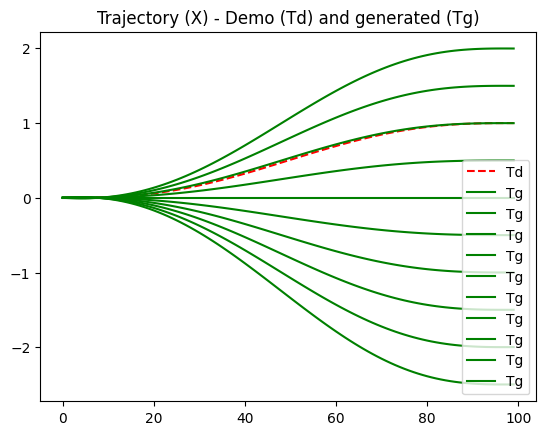

In [8]:
"""
Train a DMP with a min-jerk traj and reproduce it with different goals.
"""
n_samples = 1
dims      = 1
bfs       = 20
tau       = 1.

# Data generation
trajs_demo = min_jerk_trajs(dims=dims, n_samples=n_samples)

# Learn via DMP original/improved
dmp = DMPs_discrete(dims=dims, bfs=bfs, tau=tau)
dmp.learn(trajs_demo)

# ReProduce a trajectory
y0    = None
trajs = []

#------------------------------------------------------------
# Place your code here
for i in range(10):
    goal = np.array([1.0*((i-5)/2.0),])
    traj, _, _ = dmp.plan(y0=y0, goal=goal)
    trajs.append(traj)
#------------------------------------------------------------

# Reproduction w/ visualization
dmp.plot_traj(trajs_demo, np.array(trajs))


## C. Implement the original DMPs that learn and reproduce multiple minimum-jerk trajectory.

You must complete a function: learn(). Please, extract the learned
weights and plot both demonstrated and reproduced trajectories.

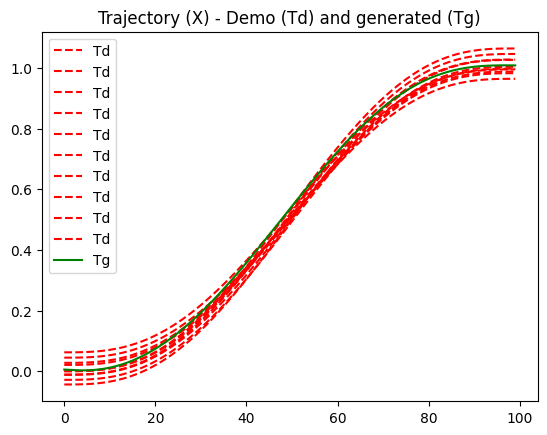

In [9]:
"""
Train DMPs with multiple min-jerk trajectories and reproduce
the demo with the same goal.
"""
n_samples = 10
dims      = 2
bfs       = 20
tau       = 1.

# Data generation
trajs_demo = min_jerk_trajs(dims=dims, n_samples=n_samples, add_noise=True)

# Learn via DMP original/improved
dmp = DMPs_discrete(dims=dims, bfs=bfs, tau=tau)
dmp.learn(trajs_demo)

# ReProduce a trajectory
traj, _, _ = dmp.plan()

# Reproduction w/ visualization
dmp.plot_traj(trajs_demo, np.expand_dims(traj, axis=0))

## D. Adapt the learned DMPs with different goals.

You must complete a function: plan(). Then, plot 10 reproduced trajectories ***trajs*** with a demonstrated trajectory, ***trajs_demo***.

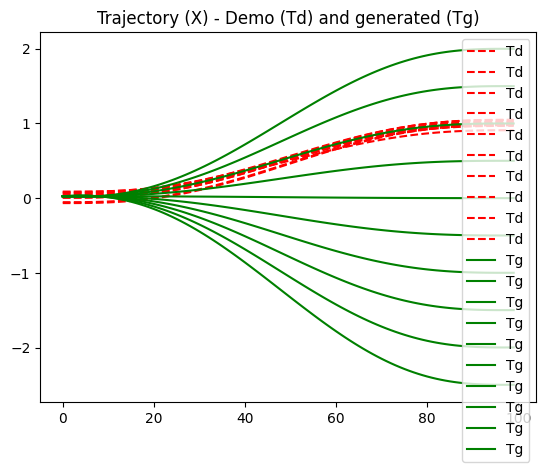

In [10]:
"""
Train DMPs with multiple min-jerk trajectories and reproduce
the demo with different goals.
"""
n_samples = 10
dims      = 2
bfs       = 20
tau       = 1.

# Data generation
trajs_demo = min_jerk_trajs(dims=dims, n_samples=n_samples, add_noise=True)

# Learn via DMP original/improved
dmp = DMPs_discrete(dims=dims, bfs=bfs, tau=tau)
dmp.learn(trajs_demo)

# ReProduce a trajectory
y0    = None
trajs = []

#------------------------------------------------------------
# Place your code here
for i in range(10):
    goal = np.array([1.0*((i-5)/2.0), 1.0*((i-5)/2.0)])
    traj, _, _ = dmp.plan(y0=y0, goal=goal)
    trajs.append(traj)
#------------------------------------------------------------

# Reproduction w/ visualization
dmp.plot_traj(trajs_demo, np.array(trajs))

## [Advanced] you can try to use handwriting dataset instead of the minimum-jerk trajectory.

 you can try to use handwriting dataset instead of the minimum-jerk trajectory. Please, Check https://cs.stanford.edu/people/khansari/download.html